<a href="https://colab.research.google.com/github/jordan-dsouza/Projects/blob/main/Age%2C%20Gender%20%26%20Ethnicity%20Prediction/Age_Gender_Eth_GenderPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

Saving kaggle.json to kaggle.json
 90% 57.0M/63.2M [00:01<00:00, 55.7MB/s]
100% 63.2M/63.2M [00:01<00:00, 55.9MB/s]


In [ ]:
!unzip age-gender-and-ethnicity-face-data-csv.zip

Archive:  age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras import layers as L, models
import tensorflow as tf
sns.set()

In [ ]:
#Reading csv file:
df = pd.read_csv("age_gender.csv")
#Converting values in "pixels" column to array:
df["pixels"]=df["pixels"].apply(lambda x:  np.array(x.split(), dtype="float32"))
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [ ]:
#Rows and columns:
print(f"Dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")

Dataframe has 23705 rows and 5 columns.


#**EDA:**

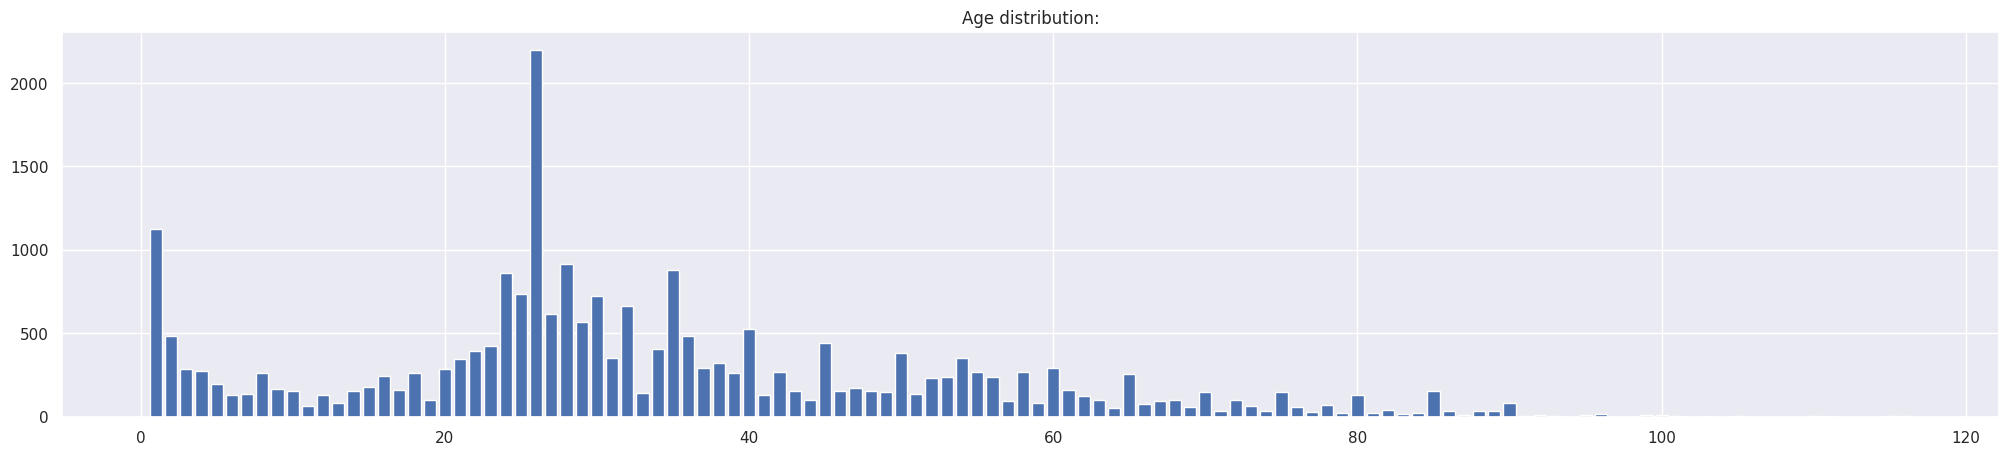

In [ ]:
plt.figure(figsize = (25,5))
age_d = df["age"].value_counts()
plt.bar(age_d.index, age_d.values)
plt.title("Age distribution:")
plt.show()

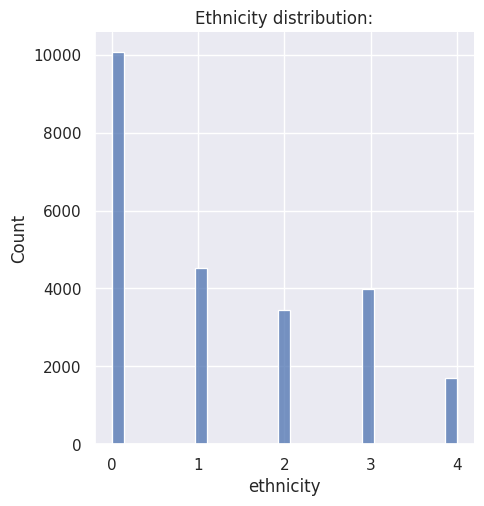

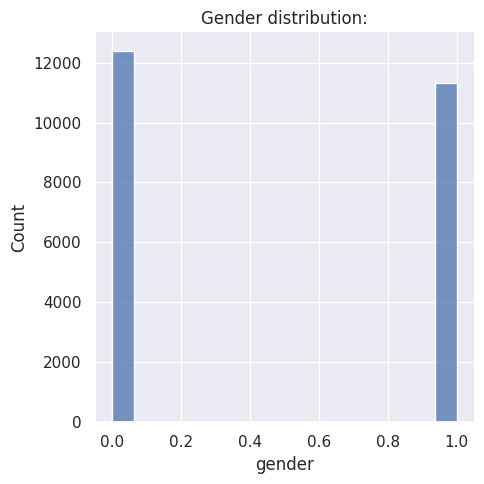

In [ ]:
sns.displot(df["ethnicity"])
plt.title("Ethnicity distribution:")
plt.show()

sns.displot(df["gender"])
plt.title("Gender distribution:")
plt.tight_layout()
plt.show()

Normalizing pixel values so it falls between 0 and 1:

In [ ]:
df["pixels"] = df["pixels"].apply(lambda x: x/255)

In [ ]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[0.5058824, 0.5019608, 0.5019608, 0.49411765, ..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[0.6431373, 0.2901961, 0.43529412, 0.65882355,..."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[0.2627451, 0.27450982, 0.2784314, 0.27450982,..."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[0.75686276, 0.77254903, 0.7764706, 0.78431374..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[0.7921569, 0.8039216, 0.81960785, 0.8235294, ..."


In [ ]:
#Adding all pixels column values into an array:
X = np.array(df["pixels"].tolist())
#1D to 4D array:
#X.shape[0] - Number of images, 48x48 pixel img, 1 - grayscale:
X = X.reshape(X.shape[0], 48, 48, 1)

In [ ]:
#X shape (4D array):
X.shape

(23705, 48, 48, 1)

#**Split data into train / test:**

In [ ]:
from sklearn.model_selection import train_test_split
y = df["gender"]
#20% data for test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
print(f"X_train shape = {X_train.shape} and y_train shape = {y_train.shape}")
print(f"\nX_test shape = {X_test.shape} and y_test shape = {y_test.shape}")

X_train shape = (18964, 48, 48, 1) and y_train shape = (18964,)

X_test shape = (4741, 48, 48, 1) and y_test shape = (4741,)


#**Model:**

In [ ]:
model = tf.keras.Sequential([
    #This layer defines the input shape for the model:
    L.InputLayer(input_shape=(48,48,1)),
    #1st convolutional layer, ReLu for non linearity:
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    #Normalizes output of previous layer to improve training stability and speed:
    L.BatchNormalization(),
    #Reduces spatial dimensions by factor of 2 socomplexity and parameters reduce:
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    #2D feature map to 1D vector:
    L.Flatten(),
    #Adds more non-linearity:
    L.Dense(64, activation='relu'),
    #50% inputs dropped to prevent overfitting:
    L.Dropout(rate=0.5),
    #Sigmoid produces probability score between 0 and 1:
    L.Dense(1, activation='sigmoid')
])


In [ ]:
#Model summary:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                        

##**Compile model:**

In [ ]:
#sgd - Stochastic gradent descent:
model.compile(optimizer="sgd",
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

##**Stop to prevent loss:**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback with patience
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)


##**Fitting model:**

In [ ]:
#validation_split = 0.1 => 10% of dataset used for validation set:
fit_model = model.fit(X_train, y_train, validation_split = 0.1, callbacks=[early_stopping_callback], epochs = 20, batch_size = 100)

Epoch 1/20
171/171 [==============================] - 63s 366ms/step - loss: 0.1928 - accuracy: 0.9241 - val_loss: 0.2330 - val_accuracy: 0.8988
Epoch 2/20
171/171 [==============================] - 57s 336ms/step - loss: 0.1853 - accuracy: 0.9269 - val_loss: 0.2349 - val_accuracy: 0.8962
Epoch 3/20
171/171 [==============================] - 61s 358ms/step - loss: 0.1848 - accuracy: 0.9275 - val_loss: 0.2350 - val_accuracy: 0.8951
Epoch 4/20
171/171 [==============================] - 59s 344ms/step - loss: 0.1815 - accuracy: 0.9294 - val_loss: 0.2296 - val_accuracy: 0.9004
Epoch 5/20
171/171 [==============================] - 59s 346ms/step - loss: 0.1776 - accuracy: 0.9303 - val_loss: 0.2303 - val_accuracy: 0.8983
Epoch 6/20
171/171 [==============================] - 58s 342ms/step - loss: 0.1728 - accuracy: 0.9316 - val_loss: 0.2338 - val_accuracy: 0.9030
Epoch 7/20
171/171 [==============================] - 60s 353ms/step - loss: 0.1728 - accuracy: 0.9331 - val_loss: 0.2354 - val_ac

In [ ]:
import plotly.express as px
figure = px.line(
    fit_model.history, y=["loss", "val_loss"],
    labels={"index": "epoch", "value": "loss"}, title="Training History")
figure.show()

In [ ]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print("Test loss: {}".format(loss))
print("Test Accuracy: {}".format(acc))

Test loss: 0.25145238637924194
Test Accuracy: 0.8953807353973389
